In [1]:
import os
import torch
import copy
import einops

import plotly.graph_objects as go
import numpy as np

from pathlib import Path
from transformers_mod import Config, Transformer, Trainer
from helpers_mod import root as root_folder
from functools import partial
from plot import add_axis_toggle

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
high_level_root = Path(os.getcwd())

In [5]:
html_dir = high_level_root/'htmls'

In [33]:
if not os.path.exists(html_dir):
    os.makedirs(html_dir)

In [6]:
phase_names = ['memorization', 'circuit_formation', 'cleanup']

In [7]:
subdirs = os.listdir(high_level_root/root_folder)

In [140]:
plot_name_template = ['excluded_loss_mean', 'restricted_loss', 'restricted_loss_ratio', 'sum_sq_weight_total']

In [161]:
pos_dict = {'memorization': [1500, 7000, 12000], 'circuit_formation': [1500 , 2200], 'cleanup': [1400, 1800]}

In [112]:
def to_numpy(tensor, flat=False):
    if isinstance(tensor, np.ndarray):
        return tensor
    elif isinstance(tensor, list):
        # if isinstance(tensor[0])
        tensor = [to_numpy(t) for t in tensor]
        return np.stack(tensor, axis=0)
    elif isinstance(tensor, torch.Tensor):
        if flat:
            return tensor.flatten().detach().cpu().numpy()
        else:
            return tensor.detach().cpu().numpy()
    elif type(tensor) in [int, float, bool, str]:
        return np.array(tensor)
    else:
        raise ValueError(f"Input to to_numpy has invalid type: {type(tensor)}")

# to_numpy([metric_cache['excluded_loss_2D_full'], metric_cache['train_loss'],  metric_cache['test_loss']])

In [31]:
def write_image(fig, name, file_type='pdf', apply_template=True, caption='', interpretation=''):
    fig.show("vscode+colab")
    html = fig.to_html(include_plotlyjs='cdn')
    fig.write_html(html_dir/f"{name}.html")
    # print(html)

In [52]:
def lines(lines_list, x=None, mode='lines', line_labels=None, xaxis='', yaxis='', title = '', log_y=False, hover=None, return_fig = False, **kwargs):
    '''Helper function to plot multiple lines'''
    labels = line_labels
    if type(lines_list)==torch.Tensor:
        lines_list = [lines_list[i] for i in range(lines_list.shape[0])]
    if x is None:
        x=np.arange(len(lines_list[0]))
    fig = go.Figure(layout={'title':title})
    fig.update_xaxes(title=xaxis)
    fig.update_yaxes(title=yaxis)
    for c, line in enumerate(lines_list):
        if type(line)==torch.Tensor:
            line = to_numpy(line)
        if labels is not None:
            label = labels[c]
        else:
            label = c
        fig.add_trace(go.Scatter(x=x, y=line, mode=mode, name=label, hovertext=hover, **kwargs))
    if log_y:
        fig.update_layout(yaxis_type="log")
    if return_fig:
        return fig
    fig.show()

In [104]:
tracked_metrics = ['test_loss', 'train_loss', 'trig_loss', 'excluded_loss_2D_full', 'sum_sq_weights', 'excluded_loss_mean']

In [119]:
max_epoch = 30100
# max_epoch = config.num_epochs
data_resolution = config.save_every
# data_resolution = config.take_metrics_every_n_epochs
epochs = [epoch for epoch in range(0, max_epoch, data_resolution)]

In [105]:
# note: change device to cpu for this as we dont need to move model to GPU to calculate metrics
config = Config()

In [192]:
subdir = subdirs[1]
print(subdir)

memorization_1699560674


In [193]:
subdir_strip = '_'.join(subdir.split('_')[:-1])
print(subdir_strip)

memorization


In [194]:
metric_cache = {tracked_metric:[] for tracked_metric in tracked_metrics}
# print(metric_cache)

In [195]:
folder_root =  high_level_root/root_folder/subdir

In [196]:
save_dict =  torch.load(folder_root/'final.pth', map_location=torch.device('cpu'))

In [197]:
metric_cache['test_loss'] = [save_dict['test_losses'][epoch] for epoch in epochs]
metric_cache['train_loss'] = [save_dict['train_losses'][epoch] for epoch in epochs]
# print(metric_cache)

In [198]:
for epoch in epochs:
    print(f'get train test loss for epoch {epoch}')
    # save_dict = torch.load(folder_root/f"{epoch}.pth", map_location=torch.device('cpu'))
    # metric_cache['test_loss'].append(save_dict['test_loss'])
    # metric_cache['train_loss'].append(save_dict['train_loss'])
    
    metrics_fname = folder_root/f"{epoch}_metrics.pth"
    if not os.path.isfile(metrics_fname):
        print(f'metrics for epoch {epoch} missing, calculating')
        print('loading model')
        model = Transformer(config=config, use_cache=False, use_ln=config.use_ln)
        save_dict = torch.load(folder_root/f"{epoch}.pth", map_location=torch.device('cpu'))
        model.load_state_dict(save_dict['model'])
        print('loading trainer')
        world = Trainer(config=config, model=model, run_name=subdir, use_time=False, use_wandb=False)
        world.take_metrics(epoch = epoch, train = world.train, log_to_wandb=False)
        
    print('load metrics')
    metrics = torch.load(metrics_fname, map_location=torch.device('cpu'))
    metric_cache['trig_loss'].append(metrics['trig_loss'])
    metric_cache['excluded_loss_2D_full'].append(metrics['excluded_loss'])
    metric_cache['sum_sq_weights'].append(metrics['sum_of_squared_weights'])


get train test loss for epoch 0
load metrics
get train test loss for epoch 100
load metrics
get train test loss for epoch 200
load metrics
get train test loss for epoch 300
load metrics
get train test loss for epoch 400
load metrics
get train test loss for epoch 500
load metrics
get train test loss for epoch 600
load metrics
get train test loss for epoch 700
load metrics
get train test loss for epoch 800
load metrics
get train test loss for epoch 900
load metrics
get train test loss for epoch 1000
load metrics
get train test loss for epoch 1100
load metrics
get train test loss for epoch 1200
load metrics
get train test loss for epoch 1300
load metrics
get train test loss for epoch 1400
load metrics
get train test loss for epoch 1500
load metrics
get train test loss for epoch 1600
load metrics
get train test loss for epoch 1700
load metrics
get train test loss for epoch 1800
load metrics
get train test loss for epoch 1900
load metrics
get train test loss for epoch 2000
load metrics
get 

In [199]:
for excluded_loss_vec in metric_cache['excluded_loss_2D_full']:
    metric_cache['excluded_loss_mean'].append(to_numpy(excluded_loss_vec).mean())

In [200]:
metric_cache['test_loss'] = to_numpy(metric_cache['test_loss'])

In [201]:
metric_cache['trig_loss'] = to_numpy(metric_cache['trig_loss'])

In [202]:
metric_cache['sum_sq_weights'] = to_numpy(metric_cache['sum_sq_weights'])

In [203]:
plot_metric = partial(lines, x=epochs, xaxis='Epoch', log_y=True)

In [204]:
names = [plot_name + f'_{subdir_strip}' for plot_name in plot_name_template]
print(names)

['excluded_loss_mean_memorization', 'restricted_loss_memorization', 'restricted_loss_ratio_memorization', 'sum_sq_weight_total_memorization']


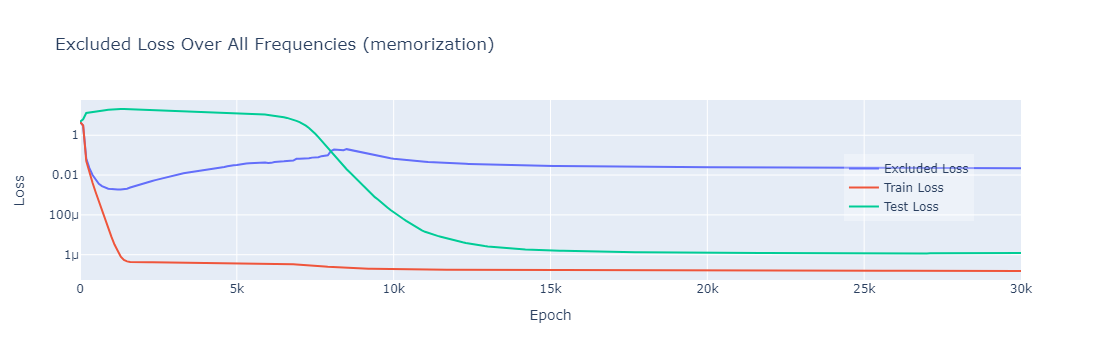

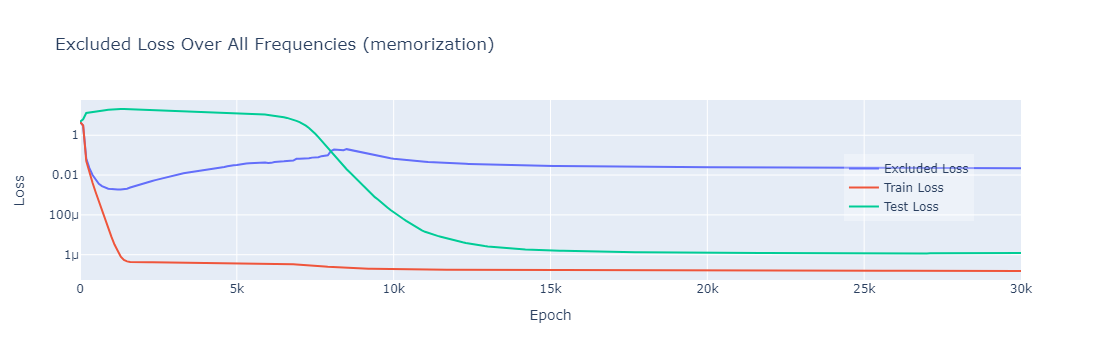

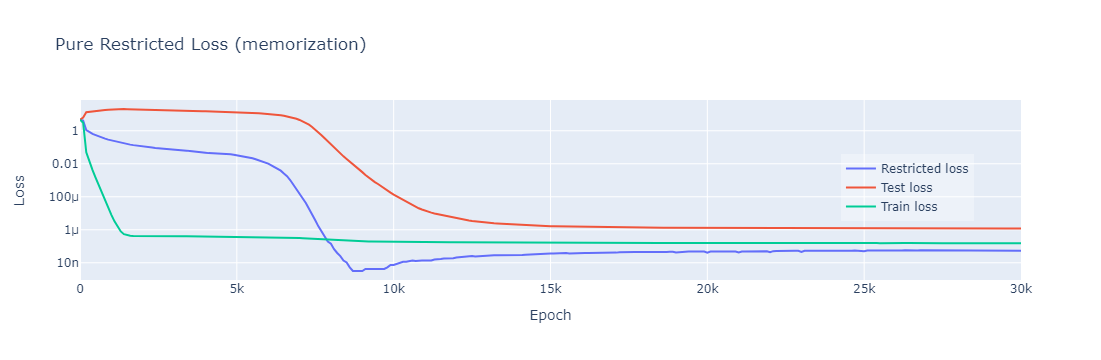

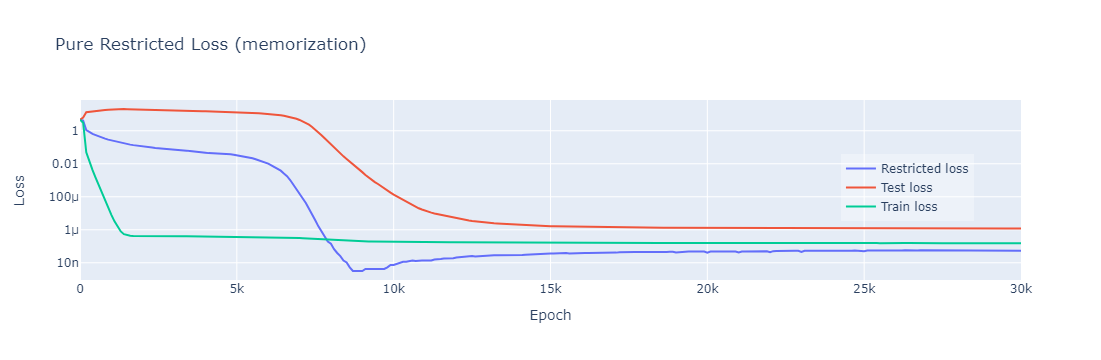

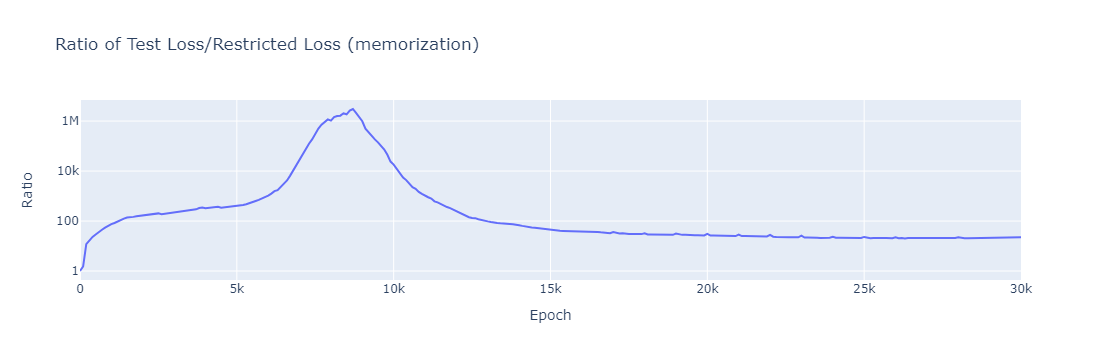

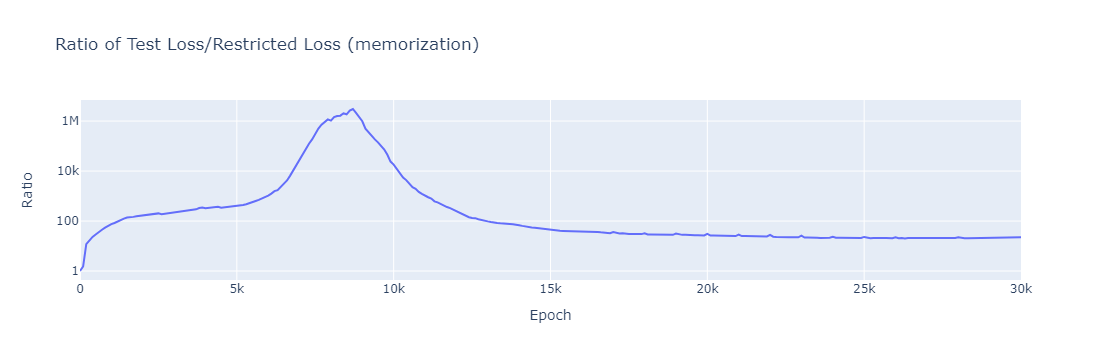

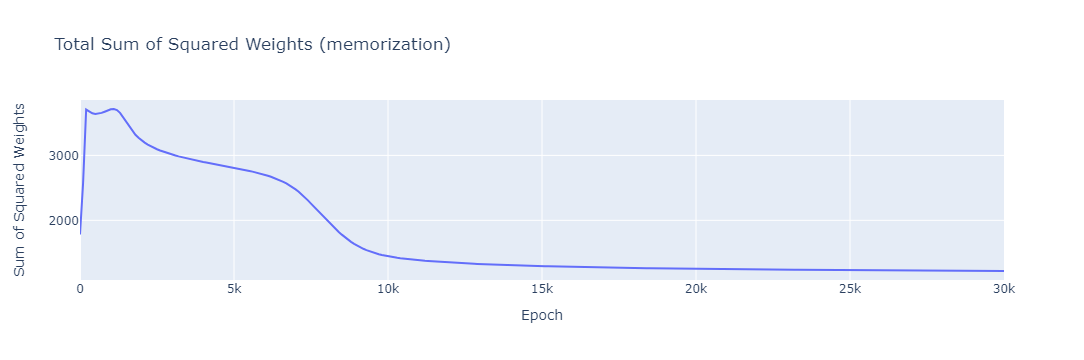

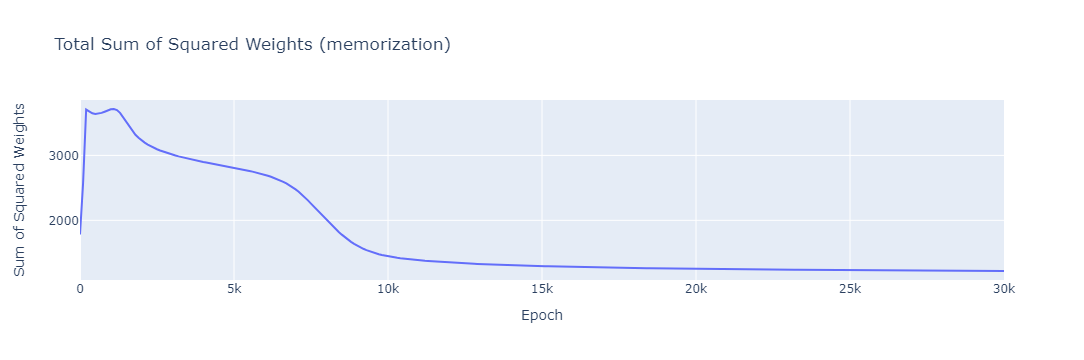

In [205]:
figures = [None]*4
legend_in_plot_dict = {'xanchor': 'right',
 'x': 0.95,
 'title': '',
 'orientation': 'v',
 'y': .7,
 'yanchor': 'top',
 'bgcolor': 'rgba(255, 255, 255, 0.3)'}
fig = lines([metric_cache['excluded_loss_mean'], metric_cache['train_loss'],  metric_cache['test_loss']],
      line_labels=['Excluded Loss', 'Train Loss', 'Test Loss'],
            # labels=['Excluded Loss', 'Train Loss', 'Test Loss'],
      title='Excluded Loss Over All Frequencies' + f' ({subdir_strip})',
      log_y=True,
      x=epochs,
      xaxis='Epoch',
      yaxis='Loss',
      return_fig = True)
fig.update_layout(legend=legend_in_plot_dict)
fig.show("vscode+colab")
write_image(fig, names[0])
figures[0] = fig


line_labels = ['trig_loss', 'test_loss', 'train_loss']
human_readable_line_labels = ['Restricted loss', 'Test loss', 'Train loss']
fig = plot_metric([metric_cache[lab] for lab in line_labels], 
                  line_labels=human_readable_line_labels, 
                  title='Pure Restricted Loss'+ f' ({subdir_strip})', 
                  yaxis='Loss',
                  return_fig=True)
fig.update_layout(legend=legend_in_plot_dict)
fig.update_layout(legend_orientation='v')
fig.show("vscode+colab")
write_image(fig, names[1])
figures[1] = fig


# line_labels = ['test_loss', 'train_loss', 'trig_loss', 'trig_loss_train']
# ratio = [test_loss/trig_loss for (test_loss, trig_loss) in zip(metric_cache['test_loss'], metric_cache['trig_loss'])]
fig = plot_metric([metric_cache['test_loss']/metric_cache['trig_loss']],
# fig = plot_metric([ratio],
            title='Ratio of Test Loss/Restricted Loss'+ f' ({subdir_strip})',
            yaxis='Ratio',
            return_fig=True)
fig.show("vscode+colab")
write_image(fig, names[2])
figures[2] = fig


fig = plot_metric([einops.reduce(metric_cache['sum_sq_weights'], 'epoch param -> epoch', 'sum')], 
# fig = plot_metric([metric_cache['sum_sq_weights']], 
            title='Total Sum of Squared Weights'+ f' ({subdir_strip})',
            log_y=False,
            yaxis='Sum of Squared Weights',
            return_fig = True)
fig.show("vscode+colab")
write_image(fig, names[3])
figures[3] = fig

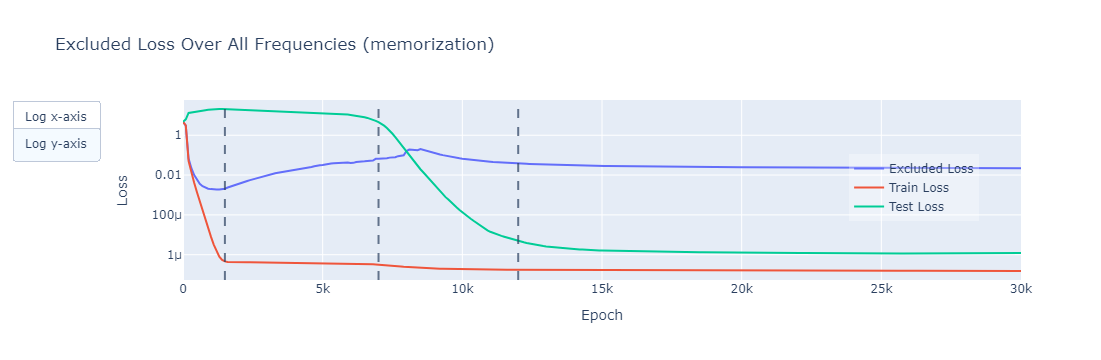

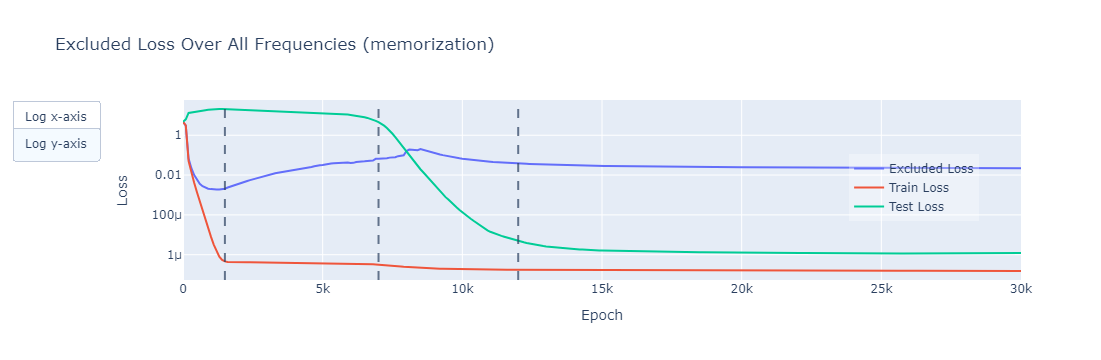

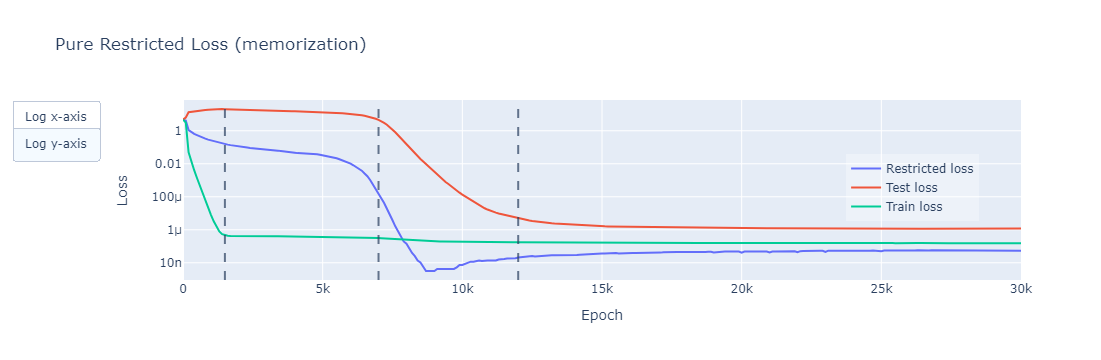

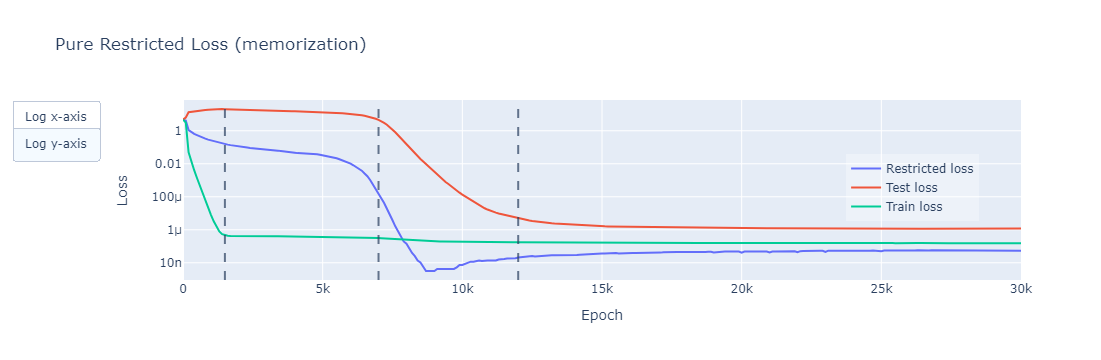

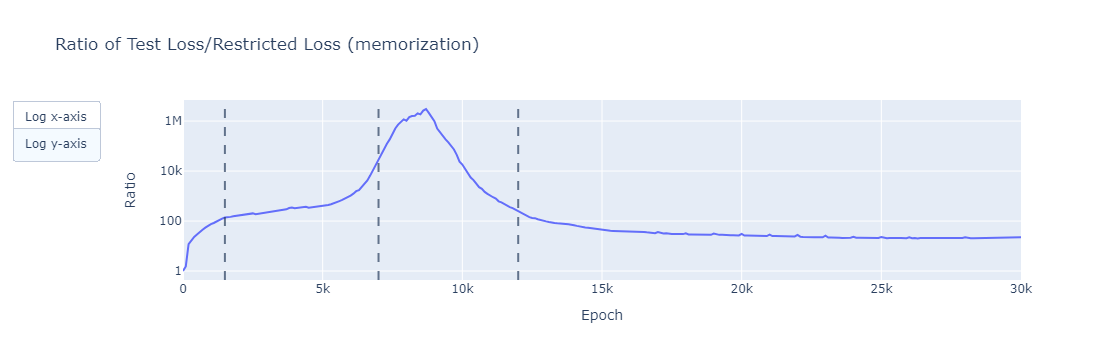

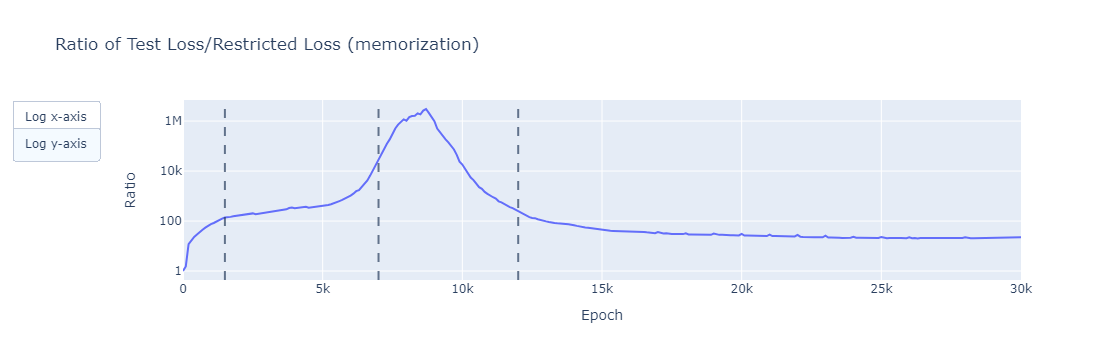

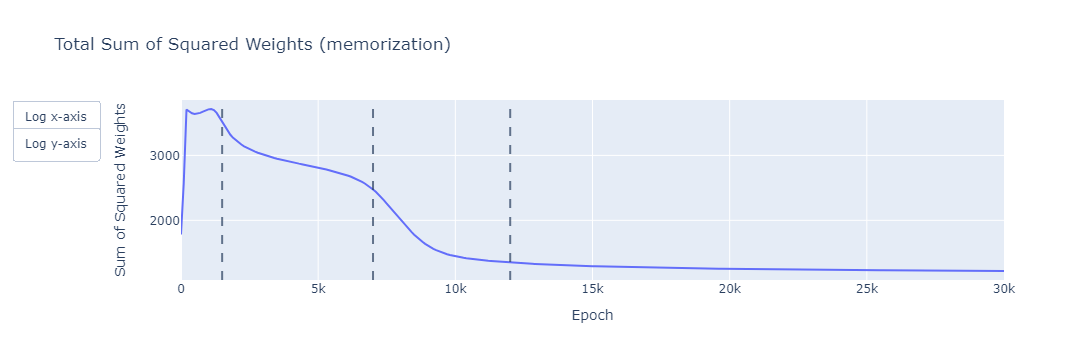

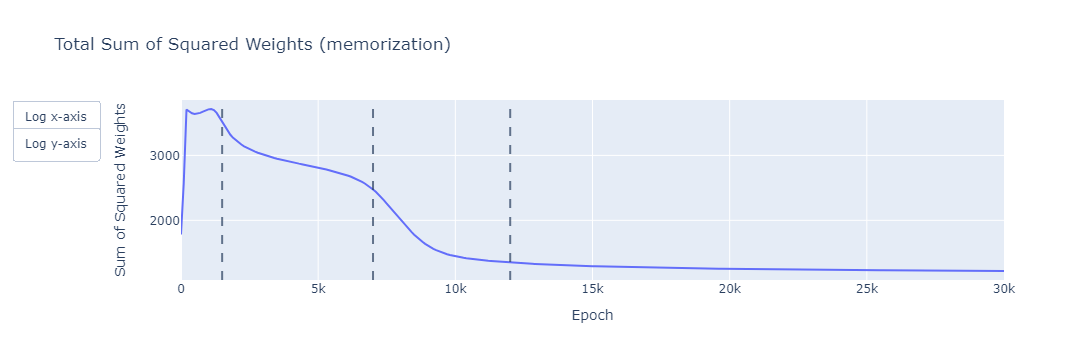

In [206]:
positions = pos_dict[subdir_strip]
for fig, name in zip(figures, names):
    fig = copy.deepcopy(fig)
    for pos in positions:
        fig.add_vline(pos,
                      line_dash='dash',
                      opacity=0.7)
    add_axis_toggle(fig.layout, 'x')
    add_axis_toggle(fig.layout, 'y')
    fig.show("vscode+colab")
    write_image(fig, name)